In [22]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE  = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}


    training_data = []
    catcount = 0
    dogcount = 0


    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try :
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats : ", self.catcount)
        print("Dogs: ", self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [23]:
training_data = np.load("training_data.npy", allow_pickle= True)

In [24]:
len(training_data)

24946

In [25]:
training_data[1]

array([array([[ 51,  46,  36, ...,  94,  90,  87],
              [ 49,  43,  36, ...,  92,  91,  94],
              [ 43,  36,  33, ...,  46,  30,  79],
              ...,
              [  2,   6,  62, ...,  74,  71, 118],
              [ 14,   9,  65, ..., 103, 106, 110],
              [ 23,  15,  64, ...,  96, 102,  95]], dtype=uint8),
       array([1., 0.])], dtype=object)

In [26]:
import matplotlib.pyplot as plt

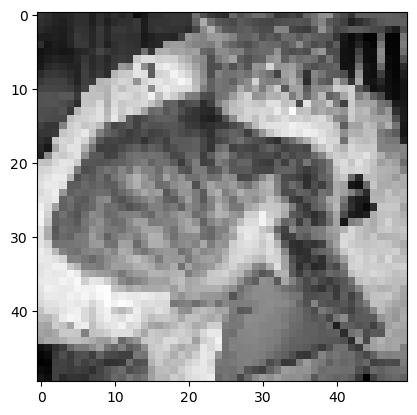

In [27]:
plt.imshow(training_data[1][0],cmap="gray")
plt.show()

In [50]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        # print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x,dim=1)


net = Net()
mps_device = torch.device("mps")
net.to(mps_device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [52]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()

X = torch.tensor([i[0] for i in training_data],dtype=torch.float,device=mps_device).view(-1,50,50)

X = X / 255.0

y = torch.tensor([i[1] for i in training_data],dtype=torch.float,device=mps_device)

VAL_PCT = 0.1

val_size = int(len(X)*VAL_PCT)
print(val_size)


2494


In [53]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))

22452


In [63]:
BATCH_SIZE = 50

EPOCHS = 10


for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        # print(i,i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()

print(loss)

100%|██████████| 450/450 [00:07<00:00, 56.51it/s]

tensor(2.0959e-08, device='mps:0', grad_fn=<MseLossBackward0>)


In [64]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Acc",round(correct/total,3))

100%|██████████| 2494/2494 [00:04<00:00, 540.44it/s]

Acc 0.744
